# Force Quant

## Install dependencies

In [15]:
%%capture
%pip install -U langchain_core langgraph requests beautifulsoup4

## Import packages

In [2]:
import operator
from typing import Annotated, Any, Sequence, Dict, Optional, Tuple, List
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
import requests # used to access wikipedia
from bs4 import BeautifulSoup # used to process HTML from wikipedia
from IPython.display import display, HTML, Image
import os # for referencing environment variables
from dotenv import load_dotenv # for loading environment variables 
import yfinance as yf # used to obtain P/E ratios
from tavily import TavilyClient # used to search web for context
from langchain_anthropic import ChatAnthropic 
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import Literal

model = 'claude-3-5-sonnet-20240620'

## Environment Variables

In [3]:
load_dotenv() # load environment variables from .env file

True

## State class

In [4]:
class PortersForceScore(BaseModel):
    '''
    A score for a specific Porters 5 Force, including explaination.
    '''
    force: Literal[
        'Competitive Rivalry',
        'Threat of new Entrants',
        'Supplier Power',
        'Customer Power',
        'Threat of Substitutes'
    ] = Field(
        ...,
        alias='force_name',
        description='''The Porters 5 Force being scored.'''
        )
    score: float = Field(
        ...,
        alias='force_score',
        description='''A score in the range of -10 (worse for the company) to +10 (better for the company).'''
        )
    justification: str = Field(
        ...,
        alias='force_justification',
        description='''A 2-3 sentence explaination for how the score was derived.'''
        )
    class Config:
        allow_population_by_field_name = True

In [5]:
class PortersFiveForcesSummary(BaseModel):
    '''
    A summary of Porter's Five Forces analysis, including average score.
    '''
    forces: List[PortersForceScore] = Field(
        ...,
        alias='forces_scores',
        description='''A list of scores for each of the five forces.'''
    )

    @property
    def average_score(self) -> float:
        '''
        Calculate the average score of the provided Porters 5 Forces.
        '''
        total_score = sum(force.score for force in self.forces)
        return total_score / len(self.forces)
    
    class Config:
        allow_population_by_field_name = True

In [6]:
def merge_dictionaries(dict1, dict2):
    '''
        Merges two dictionaries, giving priority to keys and values from dict1.
    '''
    # Start with a copy of dict1 to ensure its keys and values are prioritized
    merged_dict = dict1.copy()
    
    # Add keys and values from dict2 that are not in dict1
    for key, value in dict2.items():
        if key not in merged_dict:
            merged_dict[key] = value
    
    return merged_dict

In [7]:
def merge_summaries(summary1: PortersFiveForcesSummary, summary2: PortersFiveForcesSummary) -> PortersFiveForcesSummary:
    '''
    Merge two instances of PortersFiveForcesSummary, keeping unique forces and retaining summary1's version of duplicates.
    '''
    if summary1 is None or summary1 == '':
        summary1 = PortersFiveForcesSummary(forces_scores=[])
    if summary2 is None or summary2 == '':
        summary2 = PortersFiveForcesSummary(forces_scores=[])

    # Create a dictionary for summary1 forces using the original attribute names
    force_dict: Dict[str, PortersForceScore] = {force.force: force for force in summary1.forces}
    
    # Add unique forces from summary2, ignoring duplicates
    for force in summary2.forces:
        if force.force not in force_dict:
            force_dict[force.force] = force
    
    # Create a new summary with merged forces using the alias 'forces_scores'
    merged_summary = PortersFiveForcesSummary(forces_scores=list(force_dict.values()))

    return merged_summary

In [8]:
class State(TypedDict):
    ticker: Annotated[str, lambda a, b: a if len(a)>0 else b] 
    forces: Annotated[Dict, lambda a, b: a if len(a)>0 else b]
    in_spx: Annotated[bool, lambda a, b: a if a else b]
    company_name: Annotated[str, lambda a, b: a if len(a)>0 else b]
    current_premium: Annotated[float, lambda a, b: max(a,b)]
    target_premium: Annotated[float, lambda a, b: a if a != 0 else b] 
    expected_return: Annotated[float, lambda a, b: a if a != 0 else b] 
    force_context: Annotated[Dict, merge_dictionaries]
    #summary: Annotated[str,merge_summaries]
    summary: Annotated[PortersFiveForcesSummary,merge_summaries]
    messages: Annotated[list, operator.add]

### _dummy node_

In [9]:
def dummy_node(state: State) -> State:
    return {"messages": ["intermediate message"]}

## Node and edge functions

In [10]:
def is_in_snp(ticker: str) -> Tuple[bool, Optional[str]]:
    ''' 
        Checks if the given ticker is a member of the S&P 500 index.
        Disclaimer: uses wikipedia. A production version of this 
        function should use a more reliable source.
    '''
    # Fetch the S&P 500 list from Wikipedia
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Find the table containing the S&P 500 tickers
    table = soup.find('table', {'id': 'constituents'})
    rows = table.find_all('tr')[1:]  # Skip the header row

    # Extract tickers from the table
    sp500_tickers = [row.find_all('td')[0].text.strip() for row in rows]

    # Extract company names from the table
    sp500_companies = [row.find_all('td')[1].text.strip() for row in rows]

    # Check if the given ticker is in the S&P 500 list
    is_in_spx = ticker.upper() in sp500_tickers

    # If the ticker is in the S&P 500 list, print the company name
    if is_in_spx:
        company_name = sp500_companies[sp500_tickers.index(ticker.upper())]
        #print(f"{ticker} is in the S&P 500 index. Company name: {company_name}")
    else:
        company_name = None
        #print(f"{ticker} is not in the S&P 500 index")
    return is_in_spx, company_name

def is_evaluation_valid(state: State) -> bool:
    return True

def populate_company_info(state: State) -> Sequence[str]:
    in_spx, company_name = is_in_snp(state["ticker"])
    state["in_spx"] = in_spx
    state["company_name"] = company_name
    return state

def validate_snp(state: State) -> Sequence[str]:  
    if state["in_spx"]:
        print(f"{state['ticker']} is in the S&P 500 index")
        return [
            "Calculate Current Premium", 
            "Estimate Target Premium"
        ]
    else:
        print(f"{state['ticker']} is not in the S&P 500 index")
        return [END]



### _Get Current Premium_

In [11]:
def get_pe_ratio(ticker: str, useForward = False) -> float:
    '''
        Returns the forward P/E ratio of the given ticker.
    '''
    security = yf.Ticker(ticker)
    metric = 'forwardPE' if useForward else 'trailingPE'
    pe_ratio = security.info[metric]
    return pe_ratio

In [12]:
def get_current_premium(state: State) -> float:
    '''
        Returns the current premium of the given ticker,
        measured in terms of the P/E ratio relative to 
        the average for the S&P 500 index. Note that forward 
        earnings are used for individual securities but trailing 
        earnings are used for the S&P 500 index. This is based 
        on lack of data availability from the source used. 
        A production environment should use consistent multples.
    '''
    pe_ratio_ticker = get_pe_ratio(state['ticker'], useForward = True)
    pe_ratio_snp = get_pe_ratio('SPY')
    current_premium = pe_ratio_ticker / pe_ratio_snp - 1
    return {'current_premium': current_premium}

### _Estimate Target Premium_

In [13]:
def estimate_target_premium(state: State) -> State:
    target_premium = 0.20
    return {'target_premium': target_premium}

### _Calculate Expected Return_

In [14]:
def calculate_expected_return(state: State) -> State:
    target_return = state['target_premium'] / state['current_premium'] - 1
    return {'expected_return': target_return}

## Calculate Current Premium Graph

In [15]:
cp_builder = StateGraph(State)
cp_builder.add_node("Calculate Current Premium", get_current_premium)

cp_builder.add_edge(START, "Calculate Current Premium")
cp_builder.add_edge("Calculate Current Premium", END)

cp_graph = cp_builder.compile()

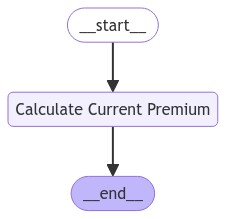

In [16]:
display(Image(cp_graph.get_graph().draw_mermaid_png()))

## Define Porter's 5 Forces

In [17]:
forces = {
    "Competitive Rivalry": [
        "what are the number and relative size of its competitors?",
        "what is the industry growth rate?",
        "what is the similarity of the company's products to its competitors?",
        "what is the size of exit barriers for competitors?",
        "what is the materiality of fixed costs?"
    ],
    "Threat of new Entrants":[
        "what are the economies of scale?",
        "how significant is product differentiation, such as strong brand identity and/or customer loyalty?",
        "what are the capital requirements?",
        "how costly or difficult is it for customers to switch from existing companies to new entrants?",
        "do new entrants have access to distribution channels or are they controlled by existing firms?"
        "do regulations restrict new entrants?"
    ],
    "Supplier Power":[
        "how many suppliers are available?",
        "how unique (not easily substituted) are the products or services of suppliers?",
        "how costly is it for the company to switch to other suppliers?",
        "how easy is it for suppliers to integrate forward into the company's industry?",
        "how much do suppliers rely on the company (and industry) for business?"
    ],
    "Customer Power":[
        "how many customers are there?",
        "how large are the orders of customers?",
        "how unique (not easily substituted) are the companys products or services?",
        "how sensitive are customers to changes in price?",
        "how savvy are customers in negotiating prices?"
    ],
    "Threat of Substitutes":[
        "what is the relative price performance of competing products or services?",
        "how willing are customers to switch to substitutes?",
        "are the comapany's products or services differentiated?",
        "are there close substitutes for the company's products or services?",
    ]
}

In [18]:
def set_forces(state: State) -> State:
    state["forces"] = forces
    return state

### Code to Calculate Force Scores

In [19]:
def get_force_context(state: State, force: str) -> str:
    '''
        Returns the context for the selected Porter's Force.
    '''
    tavily_client = TavilyClient(api_key=os.getenv('TAVILY_API_KEY'))
    company = state['company_name']
    context = ''
    for sub_force in state['forces'][force]:
        query_string = f'{company}: {sub_force}'
        addl_context = tavily_client.get_search_context(query=query_string)
        context += f'{force}:\n{addl_context}'
    return context

In [20]:
def summzarize_force_context(state: State, force: str, context: str) -> str:
    '''
        Summarize the context for the selected Porter's Force.
    '''
    llm = ChatAnthropic(model=model, temperature=0, max_tokens=4096) 
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are an expert financial analysis AI. Your task is to summarize information in a manner that is most relevant for financial analysis."),
        ("user", "Summarize the following text as it relates to {company}'s {force}. While your summary should be based on the information provided, do not tell me that it is. Just provide the summary. \n{context}")
    ])
    chain = prompt | llm
    response = chain.invoke({
        "company": state['company_name'],
        "force": force,
        "context": context
                })
    summarized_context = response.content
    return summarized_context

In [21]:
def calculate_force_score(state: State, force: str, context: str) -> PortersForceScore:
    '''
        Uses context to calculate the force score.
    '''
    llm = ChatAnthropic(model=model, temperature=0, max_tokens=4096) 
    prompt_system_text = '''
    You are an expert financial analysis AI.
    Your task is to calculatulate the expected relative outperformance (or underperformance)
    of a given company's stock. To do so, you use porters 5 forces, calculating a score for each 
    force and then combining them to get a final score.
    '''

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", prompt_system_text),
            ("human", '''
                Populate the pydantic model features for the selected porters 5 force, using the context provided.

                Selected Company: {company}
                Selected Porters 5 Force: {force}
                Context: {context}
            '''),
        ]
    )
    llm_structured_output = llm.with_structured_output(schema=PortersForceScore,include_raw=True) 
    runnable = prompt | llm_structured_output
    response = runnable.invoke({
        "company": state['company_name'],
        "force": force,
        "context": context
                })
    score = response['parsed']
    return score

In [22]:
def calculate_porter_force(state: State, force: str) -> State:
    '''
        Calculates the selected Porter's Force.
    '''
    print(f'Getting context for force: {force}...')
    context = get_force_context(state, force)
    print(f'Summarizing context for force: {force}...')
    context = summzarize_force_context(state, force, context)
    state['force_context'] = {force: context}
    print(f'Calculating score for force: {force}...')
    score = calculate_force_score(state, force, context)
    state['summary'].forces.append(score)
    print(f'Finished processing force: {force}.')
    return state

In [23]:
def calculate_porter_force_competitive_rivalry(state: State) -> State:
    return calculate_porter_force(state, 'Competitive Rivalry')

In [24]:
def calculate_porter_force_new_entrants(state: State) -> State:
    return calculate_porter_force(state, 'Threat of new Entrants')

In [25]:
def calculate_porter_force_supplier_power(state: State) -> State:
    return calculate_porter_force(state, 'Supplier Power')

In [26]:
def calculate_porter_force_customer_power(state: State) -> State:
    return calculate_porter_force(state, 'Customer Power')

In [27]:
def calculate_porter_force_substitutes(state: State) -> State:
    return calculate_porter_force(state, 'Threat of Substitutes')

## Estimate Future Premium Graph

In [28]:
ep_builder = StateGraph(State)

ep_builder.add_node("Estimate Target Premium", estimate_target_premium)

ep_builder.add_node("Competitive Rivalry", calculate_porter_force_competitive_rivalry)
ep_builder.add_node("Threat of new Entrants", calculate_porter_force_new_entrants)
ep_builder.add_node("Supplier Power", calculate_porter_force_supplier_power)
ep_builder.add_node("Customer Power", calculate_porter_force_customer_power)
ep_builder.add_node("Threat of Substitutes", calculate_porter_force_substitutes)

for force_node in forces:
    #ep_builder.add_node(force_node, dummy_node)
    ep_builder.add_edge(START, force_node)
    ep_builder.add_edge(force_node, "Estimate Target Premium")
    #ep_builder.add_conditional_edges(force_node, is_evaluation_valid, {True: "Estimate Target Premium", False: force_node})

ep_builder.add_edge("Estimate Target Premium", END)

ep_graph = ep_builder.compile()

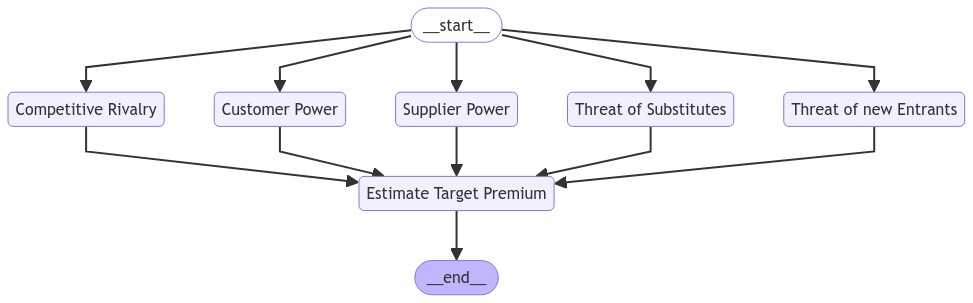

In [29]:
display(Image(ep_graph.get_graph().draw_mermaid_png()))

## Entry Graph

In [30]:
builder = StateGraph(State)
builder.add_node("Lookup Ticker",dummy_node)
builder.add_node("Set Forces", set_forces)
builder.add_node("Populate Company Info", populate_company_info)
builder.add_node("Calculate Current Premium", cp_graph)
builder.add_node("Estimate Target Premium", ep_graph)
builder.add_node("Calculate Expected Return", calculate_expected_return)

builder.add_edge(START, "Lookup Ticker")
builder.add_edge("Lookup Ticker", "Set Forces")
builder.add_edge("Set Forces", "Populate Company Info")

builder.add_conditional_edges("Populate Company Info", validate_snp, [
    "Calculate Current Premium",
    "Estimate Target Premium",
    END
])

builder.add_edge("Estimate Target Premium", "Calculate Expected Return")
builder.add_edge("Calculate Current Premium", "Calculate Expected Return")
    
builder.add_edge("Calculate Expected Return", END)
graph = builder.compile()

### Visualize Agent Graph

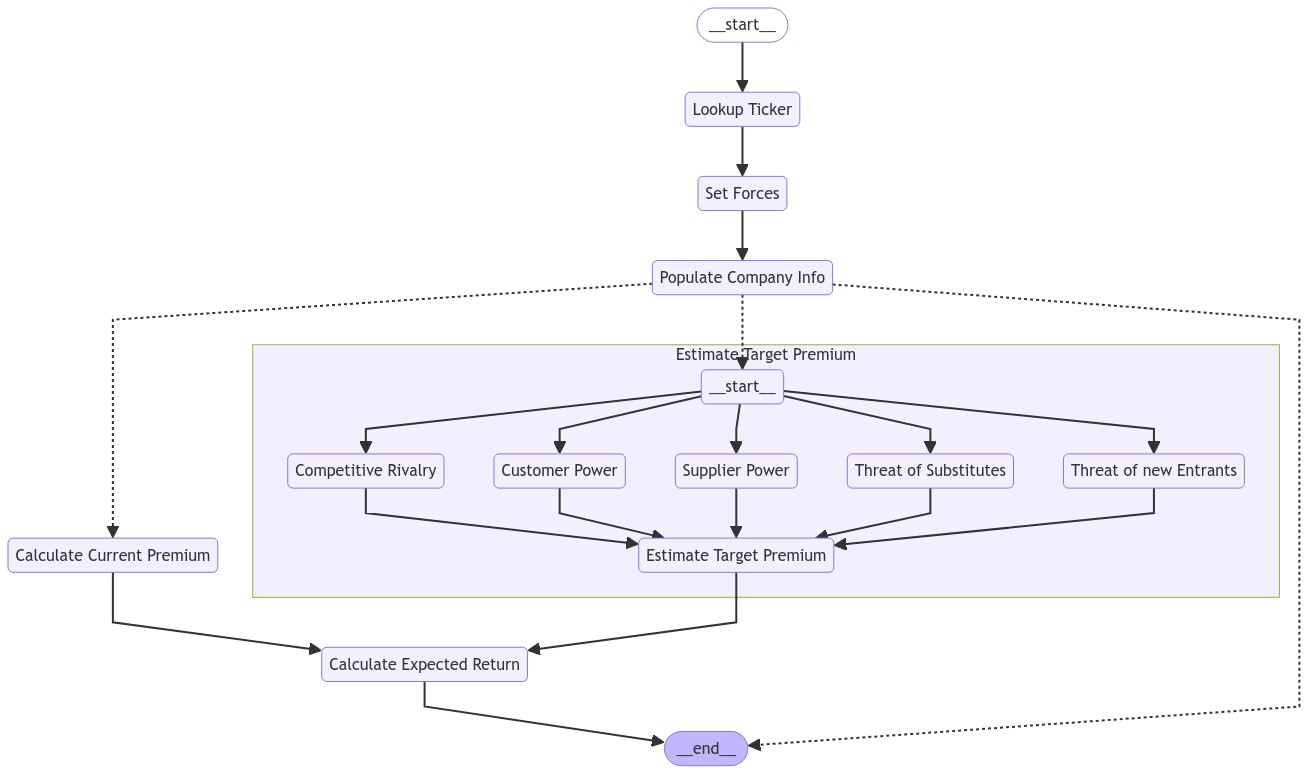

In [31]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

## Test

In [39]:
temp = str(PortersFiveForcesSummary(forces_scores=[]).json())
result = graph.invoke({"ticker":"AAPL"}, debug=False)

AAPL is in the S&P 500 index
Getting context for force: Competitive Rivalry...
Getting context for force: Threat of new Entrants...
Getting context for force: Supplier Power...
Getting context for force: Customer Power...
Getting context for force: Threat of Substitutes...
Summarizing context for force: Threat of Substitutes...
Summarizing context for force: Supplier Power...
Summarizing context for force: Customer Power...
Summarizing context for force: Competitive Rivalry...
Summarizing context for force: Threat of new Entrants...
Calculating score for force: Threat of Substitutes...
Calculating score for force: Supplier Power...
Calculating score for force: Threat of new Entrants...
Calculating score for force: Customer Power...
Calculating score for force: Competitive Rivalry...
Finished processing force: Threat of Substitutes.
Finished processing force: Threat of new Entrants.
Finished processing force: Supplier Power.
Finished processing force: Customer Power.
Finished processing

In [41]:
result

{'ticker': 'AAPL',
 'forces': {'Competitive Rivalry': ['what are the number and relative size of its competitors?',
   'what is the industry growth rate?',
   "what is the similarity of the company's products to its competitors?",
   'what is the size of exit barriers for competitors?',
   'what is the materiality of fixed costs?'],
  'Threat of new Entrants': ['what are the economies of scale?',
   'how significant is product differentiation, such as strong brand identity and/or customer loyalty?',
   'what are the capital requirements?',
   'how costly or difficult is it for customers to switch from existing companies to new entrants?',
   'do new entrants have access to distribution channels or are they controlled by existing firms?do regulations restrict new entrants?'],
  'Supplier Power': ['how many suppliers are available?',
   'how unique (not easily substituted) are the products or services of suppliers?',
   'how costly is it for the company to switch to other suppliers?',
  

## Porter's Force Calculation

In [9]:
# TEMP - DEBUG
state = {'ticker': 'AAPL',
 'forces': {'Competitive Rivalry': ['what are the number and relative size of its competitors?',
   'what is the industry growth rate?',
   "what is the similarity of the company's products to its competitors?",
   'what is the size of exit barriers for competitors?',
   'what is the materiality of fixed costs?'],
  'Threat of new Entrants': ['what are the economies of scale?',
   'how significant is product differentiation, such as strong brand identity and/or customer loyalty?',
   'what are the capital requirements?',
   'how costly or difficult is it for customers to switch from existing companies to new entrants?',
   'do new entrants have access to distribution channels or are they controlled by existing firms?do regulations restrict new entrants?'],
  'Supplier Power': ['how many suppliers are available?',
   'how unique (not easily substituted) are the products or services of suppliers?',
   'how costly is it for the company to switch to other suppliers?',
   "how easy is it for suppliers to integrate forward into the company's industry?",
   'how much do suppliers rely on the company (and industry) for business?'],
  'Customer Power': ['how many customers are there?',
   'how large are the orders of customers?',
   'how unique (not easily substituted) are the companys products or services?',
   'how sensitive are customers to changes in price?',
   'how savvy are customers in negotiating prices?'],
  'Threat of Substitutes': ['what is the relative price performance of competing products or services?',
   'how willing are customers to switch to substitutes?',
   "are the comapany's products or services differentiated?",
   "are there close substitutes for the company's products or services?"]},
 'in_spx': True,
 'company_name': 'Apple Inc.',
 'current_premium': 0.0603712058182182,
 'target_premium': 0.2,
 'expected_return': 2.312837590195127,
 'force_context': {'Competitive Rivalry': "Apple Inc. faces intense competitive rivalry in the technology industry, particularly in smartphones, personal computing, and services. Key aspects of this rivalry include:\n\n1. Strong competitors: Apple competes with major tech companies like Samsung, Microsoft, Google, Amazon, and Huawei across various product categories.\n\n2. Innovation focus: Apple emphasizes superior innovation and integration of hardware, software, and services to differentiate itself from competitors.\n\n3. Brand strength: Apple's strong brand identity and premium positioning help it maintain a competitive edge.\n\n4. Market share battles: The company faces significant competition in smartphone and personal computing markets, with rivals constantly attempting to gain market share.\n\n5. Diverse product ecosystem: Apple's competitive advantage stems from its integrated ecosystem of products and services.\n\n6. Resource-rich competitors: Some of Apple's competitors have substantial resources and may offer products at lower margins to compete.\n\n7. Intensifying competition: The tech industry is experiencing increased competition as companies imitate features and collaborate to challenge Apple's offerings.\n\n8. Multiple battlegrounds: Apple faces competition across various segments, including smartphones, computers, tablets, wearables, and services.\n\n9. Constant innovation: To maintain its competitive position, Apple must continuously innovate and improve its products and services.\n\n10. Global competition: Apple faces competition from both established global brands and regional players in various markets.\n\nThis competitive landscape requires Apple to maintain its focus on innovation, brand strength, and ecosystem integration to sustain its market position and profitability.",
  'Threat of new Entrants': "Apple Inc. faces a relatively low threat of new entrants due to several factors:\n\n1. Economies of scale: Apple's massive production scale allows for cost advantages that new entrants would struggle to match.\n\n2. Brand loyalty and customer trust: Apple has cultivated strong brand loyalty, with high customer retention rates (up to 92% in some markets) and a willingness to pay premium prices.\n\n3. Capital requirements: Entering the tech industry requires substantial investments in research, development, and marketing, creating a significant barrier for new companies.\n\n4. Intellectual property: Apple holds over 20,000 patents, protecting its proprietary technology and making it difficult for new entrants to replicate its products.\n\n5. Distribution channels: Apple has established an extensive distribution network, including its own retail stores and partnerships with major retailers, which new entrants would find challenging to replicate.\n\n6. Switching costs: Apple's ecosystem of interconnected products and services creates high switching costs for consumers, discouraging them from moving to new entrants' offerings.\n\n7. Technological expertise: Apple's long-standing experience and expertise in hardware and software development present a formidable challenge for new competitors to overcome.\n\nThese factors collectively create substantial barriers to entry, making it difficult for new companies to compete effectively with Apple in its core markets.",
  'Supplier Power': "Apple's supplier power is characterized by a complex and evolving global supply chain:\n\n1. Extensive network: Apple has over 500 suppliers across 40+ countries, with a supply chain worth an estimated $500 billion.\n\n2. Geographic diversification: While China remains a key manufacturing hub, Apple is actively diversifying its supply chain to countries like Vietnam and India to reduce reliance on any single region.\n\n3. Key suppliers: Major companies like Foxconn, Samsung, LG, Pegatron, and TSMC are critical to Apple's production, with some suppliers heavily dependent on Apple's business.\n\n4. Vertical integration: Apple exercises significant control over various aspects of its supply chain, including product design and manufacturing processes.\n\n5. Supplier commitments: Apple is pushing suppliers to adopt clean energy, with over 300 manufacturers committed to using 100% renewable energy for Apple production by 2030.\n\n6. Ethical concerns: There have been instances of suppliers violating Apple's ethics policies, including labor issues, which Apple has sometimes been slow to address.\n\n7. Strategic leverage: Apple's massive scale allows it to exert considerable influence over suppliers, often dictating terms and standards.\n\n8. Supply chain management: Apple closely manages its supply chain, conducting regular audits and pushing for improvements in quality, sustainability, and working conditions.\n\n9. Component sourcing: Apple strategically sources critical components like semiconductors, sometimes facing challenges in certain areas where expertise is concentrated.\n\n10. Shifting dynamics: Geopolitical tensions and trade issues are prompting Apple to reconsider its supply chain strategy, potentially leading to further diversification and reshoring of some production.\n\nThis complex supplier landscape gives Apple both significant advantages and challenges in managing its global supply chain and maintaining its competitive edge.",
  'Customer Power': "Apple's customer power can be summarized as follows:\n\n1. Large and loyal customer base: Despite premium pricing, Apple has a substantial global customer base due to the outstanding quality of its products and services.\n\n2. Brand loyalty and ecosystem lock-in: Apple's integrated ecosystem of products and services (iPhone, iPad, Mac, iCloud, Apple Music, etc.) creates a seamless experience that encourages customer retention.\n\n3. Premium market dominance: Apple holds over 90% market share in the $1,000+ price range for smartphones, indicating strong customer willingness to pay for premium products.\n\n4. Price inelasticity: Apple's pricing strategy suggests that demand for its products is relatively inelastic, allowing the company to maintain higher prices without significantly impacting sales.\n\n5. Emotional connection: Apple products are often viewed as luxury items, providing customers with a sense of extravagance and positive emotional experiences.\n\n6. Innovation-driven demand: Continuous innovation and product improvements keep customers engaged and willing to upgrade to newer models.\n\n7. Service integration: Apple's growing focus on services (Apple TV+, Apple Music, Apple Arcade) provides additional value to customers and strengthens their connection to the ecosystem.\n\n8. Limited price sensitivity: While Apple offers some more affordable options (e.g., iPhone SE), its core strategy remains focused on premium pricing, indicating that many customers are not highly price-sensitive.\n\n9. High customer expectations: Apple's reputation for quality and innovation has set high customer expectations, which the company must consistently meet to maintain its strong market position.\n\n10. Segmented offerings: Apple provides a range of products at different price points, allowing it to cater to various customer segments while maintaining its premium brand image.",
  'Threat of Substitutes': "Apple faces a moderate threat of substitutes across its product and service lines:\n\n1. Smartphones: Android devices from Samsung, Google, Xiaomi, and OnePlus offer viable alternatives to iPhones, providing similar functionalities and features.\n\n2. Computers: Microsoft, Dell, HP, Lenovo, and Asus compete with Apple's Mac lineup, offering Windows-based alternatives.\n\n3. Tablets: Various Android and Windows-based tablets serve as substitutes for iPads.\n\n4. Wearables: Companies like Samsung, Fitbit, and Garmin offer smartwatches and fitness trackers that compete with Apple Watch.\n\n5. Services: Spotify competes with Apple Music, while Amazon and Google offer alternatives to Apple's cloud and smart home services.\n\nHowever, Apple mitigates this threat through:\n\n1. Ecosystem integration: Apple's interconnected products and services create a closed ecosystem, increasing switching costs for users.\n\n2. Brand loyalty: Apple's strong brand image and customer loyalty reduce the likelihood of customers switching to substitutes.\n\n3. Differentiation: Apple focuses on premium positioning, innovative design, and user experience, setting its products apart from competitors.\n\n4. Continuous innovation: Regular product updates and new features help maintain Apple's competitive edge.\n\n5. Diversified product portfolio: Apple's range of products and services reduces reliance on any single offering.\n\nWhile substitutes exist, Apple's strategy of differentiation, ecosystem lock-in, and focus on user experience helps maintain its market position and reduces the overall threat of substitutes."},
 'summary': PortersFiveForcesSummary(forces=[PortersForceScore(force='Threat of Substitutes', score=5.0, justification="Apple faces moderate threat of substitutes across product lines, but mitigates this through ecosystem integration, brand loyalty, and continuous innovation. While viable alternatives exist, Apple's differentiation and ecosystem lock-in reduce the overall impact of substitutes, positioning the company favorably."), PortersForceScore(force='Threat of new Entrants', score=8.0, justification="Apple faces a low threat of new entrants due to significant barriers to entry. These include economies of scale, strong brand loyalty (92% retention rate), high capital requirements, extensive patent portfolio (20,000+ patents), established distribution channels, high switching costs within Apple's ecosystem, and deep technological expertise. These factors make it extremely challenging for new competitors to enter and compete effectively in Apple's markets."), PortersForceScore(force='Customer Power', score=-2.0, justification="Apple's customer power is relatively low, benefiting the company. The large, loyal customer base, strong brand loyalty, and ecosystem lock-in significantly reduce customer power. Premium market dominance and price inelasticity allow Apple to maintain high prices. However, high customer expectations and the need for continuous innovation slightly increase customer power, resulting in a slightly negative score."), PortersForceScore(force='Competitive Rivalry', score=6.0, justification="Apple faces intense competition but maintains a strong position due to its brand strength, innovative ecosystem, and premium positioning. While the rivalry is high, Apple's unique advantages and constant innovation allow it to outperform many competitors, justifying a positive score of 6."), PortersForceScore(force='Supplier Power', score=-7.0, justification="Apple's extensive network of 500+ suppliers across 40+ countries, coupled with its strategic leverage due to massive scale, significantly reduces supplier power. The company's vertical integration and active supply chain management further weaken supplier influence. While some key suppliers are critical, Apple's ongoing diversification efforts and ability to dictate terms maintain its strong position against supplier power.")]),
 'messages': ['intermediate message',
  'intermediate message',
  'intermediate message',
  'intermediate message',
  'intermediate message',
  'intermediate message',
  'intermediate message',
  'intermediate message',
  'intermediate message',
  'intermediate message',
  'intermediate message',
  'intermediate message',
  'intermediate message',
  'intermediate message',
  'intermediate message',
  'intermediate message',
  'intermediate message',
  'intermediate message',
  'intermediate message',
  'intermediate message',
  'intermediate message',
  'intermediate message',
  'intermediate message',
  'intermediate message',
  'intermediate message',
  'intermediate message',
  'intermediate message',
  'intermediate message',
  'intermediate message',
  'intermediate message',
  'intermediate message',
  'intermediate message']}

In [14]:
state['summary'].average_score

2.0

In [29]:
# Competitive Rivalry
# Threat of new Entrants
# Supplier Power
# Customer Power
# Threat of Substitutes
#calculate_porter_force(state, "Threat of Substitutes")

In [46]:
result['summary'] = result['summary'].json()

In [13]:
state['summary']

PortersFiveForcesSummary(forces=[PortersForceScore(force='Threat of Substitutes', score=5.0, justification="Apple faces moderate threat of substitutes across product lines, but mitigates this through ecosystem integration, brand loyalty, and continuous innovation. While viable alternatives exist, Apple's differentiation and ecosystem lock-in reduce the overall impact of substitutes, positioning the company favorably."), PortersForceScore(force='Threat of new Entrants', score=8.0, justification="Apple faces a low threat of new entrants due to significant barriers to entry. These include economies of scale, strong brand loyalty (92% retention rate), high capital requirements, extensive patent portfolio (20,000+ patents), established distribution channels, high switching costs within Apple's ecosystem, and deep technological expertise. These factors make it extremely challenging for new competitors to enter and compete effectively in Apple's markets."), PortersForceScore(force='Customer P

In [34]:
import random # TEMP - to be removed
force = 'Competitive Rivalry'
score = random.randint(-10, 10)
example_score = PortersForceScore(
    force_name=force,
    force_score=score,
    force_justification=f'Sample justification for {force} score of {score}.'
)

summary1 = PortersFiveForcesSummary(forces_scores=[example_score])
#summary1 = PortersFiveForcesSummary(forces_scores=[])

In [44]:
import random # TEMP - to be removed
force = 'Customer Power'
score = random.randint(-10, 10)
example_score = PortersForceScore(
    force_name=force,
    force_score=score,
    force_justification=f'Sample justification for {force} score of {score}.'
)

summary2 = PortersFiveForcesSummary(forces_scores=[example_score])
#summary2 = PortersFiveForcesSummary(forces_scores=[])

In [45]:
summary_combo = merge_summaries(summary1, summary2)